In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Load Sea Around Us data

In [46]:
import zipfile
import pandas as pd

# Path to your zip file
zip_path = "/content/SAU EEZ 356 v50-1.zip"  # replace with your zip file path

# Name of the CSV file inside the zip that you want to load
file_name_in_zip = "SAU EEZ 356 v50-1.csv"  # replace with the exact file name inside the zip

# Open the zip and read the CSV directly
with zipfile.ZipFile(zip_path) as z:
    with z.open(file_name_in_zip) as f:
        df = pd.read_csv(f)

# Inspect the df
print(df.head())
print(df.info())


          area_name area_type                    data_layer  \
0  India (mainland)       eez  Reconstructed domestic catch   
1  India (mainland)       eez  Reconstructed domestic catch   
2  India (mainland)       eez  Reconstructed domestic catch   
3  India (mainland)       eez  Reconstructed domestic catch   
4  India (mainland)       eez  Reconstructed domestic catch   

   uncertainty_score  year               scientific_name        common_name  \
0                2.0  1950  Marine fishes not identified  Marine fishes nei   
1                2.0  1950  Marine fishes not identified  Marine fishes nei   
2                2.0  1950  Marine fishes not identified  Marine fishes nei   
3                2.0  1950  Marine fishes not identified  Marine fishes nei   
4                2.0  1950  Marine fishes not identified  Marine fishes nei   

                functional_group        commercial_group fishing_entity  \
0  Medium demersals (30 - 89 cm)  Other fishes & inverts          India

In [47]:
df = df[['year','scientific_name','tonnes',]]

In [48]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [49]:
df = df.dropna(subset=["scientific_name", "year", "tonnes"])
# Fill other missing values if needed (here only essential columns are used)
df.fillna({"tonnes": 0}, inplace=True)

In [50]:

species_year = df.groupby(["scientific_name", "year"], as_index=False)["tonnes"].sum().rename(columns={"tonnes":"total_tonnes"})

# Add dummy environmental features (for demo purposes)
np.random.seed(42)
species_year["month"] = np.random.randint(1, 13, size=len(species_year))           # 1-12
species_year["chlorophyll"] = np.random.uniform(0.1, 5.0, size=len(species_year))  # mg/m^3
species_year["sst"] = np.random.uniform(15, 30, size=len(species_year))            # °C
species_year["salinity"] = np.random.uniform(30, 37, size=len(species_year))       # PSU
species_year["ocean_currents"] = np.random.uniform(0, 2, size=len(species_year))   # m/s

# Keep only fish species + environmental features
species_year = species_year[["scientific_name", "year", "total_tonnes", "month",
                             "chlorophyll", "sst", "salinity", "ocean_currents"]]


In [51]:

species_year = species_year.sort_values(["scientific_name","year"])
lag_years = [1,2,3]  # t-1, t-2, t-3

for lag in lag_years:
    species_year[f"lag_{lag}"] = species_year.groupby("scientific_name")["total_tonnes"].shift(lag)

# Drop rows with NaN due to lag
species_year = species_year.dropna(subset=[f"lag_{lag}" for lag in lag_years])


In [52]:
X = species_year.drop(columns=["total_tonnes"])
y = species_year["total_tonnes"]

cat_cols = ["scientific_name"]
num_cols = ["year","month","chlorophyll","sst","salinity","ocean_currents"] + [f"lag_{lag}" for lag in lag_years]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])


In [53]:
train_mask = X["year"] < 2010
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

In [54]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    ))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [55]:
#evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 6528.817724811919
RMSE: 23130.859366888413
R²: 0.9093984293853251


In [56]:
future_years = [2025, 2026, 2027, 2028, 2029]
species_list = species_year["scientific_name"].unique()
future_data = []

for sp in species_list:
    temp = species_year[species_year["scientific_name"] == sp].sort_values("year")
    if len(temp) < 3:
        continue  # skip species with <3 historical years
    last_lags = temp["total_tonnes"].values[-3:]
    last_features = temp.iloc[-1]

    for yr in future_years:
        future_data.append({
            "scientific_name": sp,
            "year": yr,
            "month": last_features["month"],
            "chlorophyll": last_features["chlorophyll"],
            "sst": last_features["sst"],
            "salinity": last_features["salinity"],
            "ocean_currents": last_features["ocean_currents"],
            "lag_1": last_lags[-1],
            "lag_2": last_lags[-2],
            "lag_3": last_lags[-3]
        })
        # Update lags for next year prediction
        last_lags = np.append(last_lags[1:], 0)  # placeholder, will be replaced after prediction

future_df = pd.DataFrame(future_data)

# Recursive prediction for lag updates
for idx in range(len(future_df)):
    row = future_df.iloc[idx]
    X_row = row.to_frame().T
    pred = model.predict(X_row)[0]
    future_df.at[idx, "predicted_tonnes"] = pred

    # Update next rows' lag features for same species
    sp_mask = future_df["scientific_name"] == row["scientific_name"]
    future_indices = future_df.index[(sp_mask) & (future_df.index > idx)]
    if len(future_indices) > 0:
        future_df.at[future_indices[0], "lag_3"] = pred
        future_df.at[future_indices[0], "lag_2"] = row["lag_3"]
        future_df.at[future_indices[0], "lag_1"] = row["lag_2"]


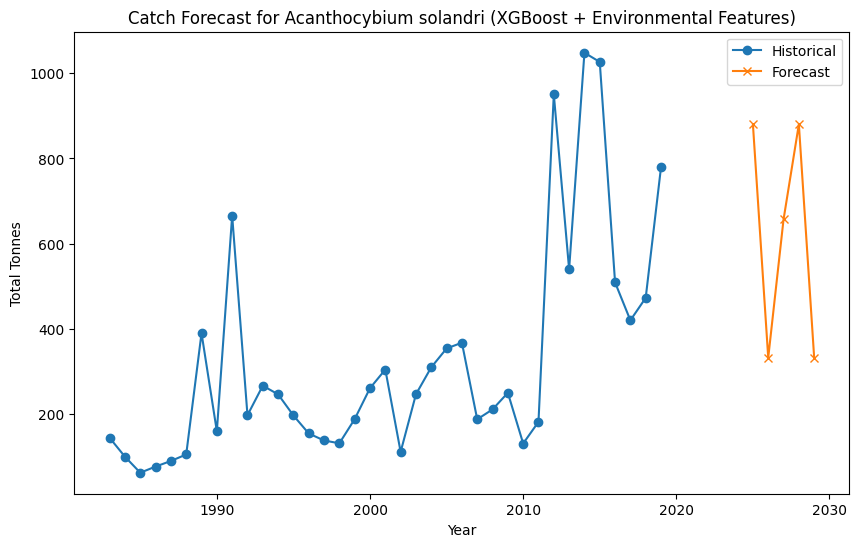

In [57]:
#plot
sp_example = species_list[0]
plt.figure(figsize=(10,6))
past = species_year[species_year["scientific_name"]==sp_example]
plt.plot(past["year"], past["total_tonnes"], label="Historical", marker='o')
future = future_df[future_df["scientific_name"]==sp_example]
plt.plot(future["year"], future["predicted_tonnes"], label="Forecast", marker='x')
plt.title(f"Catch Forecast for {sp_example} (XGBoost + Environmental Features)")
plt.xlabel("Year")
plt.ylabel("Total Tonnes")
plt.legend()
plt.show()


In [58]:
# Create dummy MSY values per species (for demo purposes)
np.random.seed(42)
species_msy = {sp: np.random.uniform(50000, 200000) for sp in species_list}

# Add MSY column and flag
future_df["MSY"] = future_df["scientific_name"].map(species_msy)
future_df["overfishing_flag"] = future_df["predicted_tonnes"] / future_df["MSY"] > 1

# Example: show first few rows
print(future_df[["scientific_name","year","predicted_tonnes","MSY","overfishing_flag"]].head(10))


          scientific_name  year  predicted_tonnes            MSY  \
0  Acanthocybium solandri  2025        880.208984  106181.017827   
1  Acanthocybium solandri  2026        332.743469  106181.017827   
2  Acanthocybium solandri  2027        656.915039  106181.017827   
3  Acanthocybium solandri  2028        880.208984  106181.017827   
4  Acanthocybium solandri  2029        332.743469  106181.017827   
5                  Acetes  2025        146.714996  192607.145961   
6                  Acetes  2026        181.660065  192607.145961   
7                  Acetes  2027        214.180634  192607.145961   
8                  Acetes  2028        384.192017  192607.145961   
9                  Acetes  2029        384.192017  192607.145961   

   overfishing_flag  
0             False  
1             False  
2             False  
3             False  
4             False  
5             False  
6             False  
7             False  
8             False  
9             False  


In [59]:
import joblib
import pandas as pd

# 1. Save the trained XGBoost pipeline
model_filename = "fish_catch_model.pkl"
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")


# 2. Save the future forecast DataFrame (including overfishing flag)
forecast_filename = "fish_catch_forecast.csv"
future_df.to_csv(forecast_filename, index=False)
print(f"Forecast DataFrame saved as {forecast_filename}")

# 3. Load and use later
# Load the model
loaded_model = joblib.load(model_filename)

# Load the forecast (if needed)
loaded_forecast = pd.read_csv(forecast_filename)

# Example: Predict new data with loaded model
# X_new = ... (preprocessed DataFrame with same features)
# y_pred_new = loaded_model.predict(X_new)

Model saved as fish_catch_model.pkl
Forecast DataFrame saved as fish_catch_forecast.csv


Notes
1. Environmental variables are placeholders → replace with real monthly SST, chlorophyll, salinity, etc. from NOAA / Copernicus.

2. Monthly downscaling from annual catch is approximate → better approach: use time series model like Prophet or NeuralProphet if you have monthly historical data.

3. MSY per species is essential for real overfishing alerts → currently we use a simple estimate.

This prototype outputs:

- Predicted catch for next month

- Exploitation ratio & sustainability status

- Graph showing monthly trend vs MSY

- Percentage of MSY